In [17]:
from MVPAnalyzer import Analyzer
import numpy as np

In [18]:
# mvpa = Analyzer('C:/Users/maxim/Documents/INGE CNRS/ESSTECH25/MVP300_DATA/Underway profile/Bbis to Abis - 6 - 6_5 Knots/')
mvpa = Analyzer('C:/Users/maxim/Documents/INGE CNRS/ESSTECH25/MVP300_DATA/Underway profile/A to B - 4 Knots/')


# Bbis to Abis - 6 - 6_5 Knots
# mvpa.load_mvp_data()

# A to B - 4 Knots
mvpa.load_mvp_data(delp=[8,9,10,11,18,19]) # manually delete profiles because the MVP was stopped and restarted during the cast

# Stationary Bathysonde
# mvpa.load_ctd_data('C:/Users/maxim/Documents/INGE CNRS/ESSTECH25/BATHYSONDE/DATA/TRAIT/CNV/')




Found 24 MVP files in the directory: C:/Users/maxim/Documents/INGE CNRS/ESSTECH25/MVP300_DATA/Underway profile/A to B - 4 Knots/
MVP data loaded successfully.


In [3]:
from netCDF4 import Dataset
import gsw
from datetime import datetime

# Concatenate MVP profiles 2 and 3 and export to NetCDF

# Select profiles to concatenate (0-based indexing)
profile_ids = [2, 3]

def concat_from_attr(obj, attr, ids):
    if not hasattr(obj, attr):
        return None
    arr = getattr(obj, attr)
    out = []
    for i in ids:
        ai = np.asarray(arr[i])
        out.append(ai.astype(float))
    return np.concatenate(out)

# Base variables (pressure as base dimension)
pres = concat_from_attr(mvpa, 'PRES_mvp', profile_ids)
temp = concat_from_attr(mvpa, 'TEMP_mvp', profile_ids)
cond = concat_from_attr(mvpa, 'COND_mvp', profile_ids)
do   = concat_from_attr(mvpa, 'DO_mvp',   profile_ids)
turb = concat_from_attr(mvpa, 'TURB_mvp', profile_ids) if hasattr(mvpa, 'TURB_mvp') else None
fluo = concat_from_attr(mvpa, 'FLUO_mvp', profile_ids) if hasattr(mvpa, 'FLUO_mvp') else None
ph   = concat_from_attr(mvpa, 'PH_mvp',   profile_ids) if hasattr(mvpa, 'PH_mvp')   else None
suna = concat_from_attr(mvpa, 'SUNA_mvp', profile_ids) if hasattr(mvpa, 'SUNA_mvp') else None

# Optional per-sample metadata (lat, lon, time) if available
def concat_meta(meta_attr, ids, like_len):
    if not hasattr(mvpa, meta_attr):
        return None
    meta = getattr(mvpa, meta_attr)
    out = []
    for i in ids:
        mi = meta[i]
        # Expand scalar per-profile metadata to per-sample if needed
        if np.isscalar(mi) or (np.asarray(mi).ndim == 0):
            # length from pressure for that profile
            n_i = len(np.asarray(getattr(mvpa, 'PRES_mvp')[i]))
            out.append(np.full(n_i, float(mi)))
        else:
            out.append(np.asarray(mi).astype(float))
    cat = np.concatenate(out)
    # If mismatched length, pad/trim to match base length
    if like_len is not None and len(cat) != like_len:
        if len(cat) > like_len:
            cat = cat[:like_len]
        else:
            pad = np.full(like_len - len(cat), np.nan)
            cat = np.concatenate([cat, pad])
    return cat

lat = concat_meta('LAT_mvp', profile_ids, len(pres)) if hasattr(mvpa, 'LAT_mvp') else None
lon = concat_meta('LON_mvp', profile_ids, len(pres)) if hasattr(mvpa, 'LON_mvp') else None

# Try to get time; handle Python datetime, numpy datetime64, or numeric
time_concat = None
if hasattr(mvpa, 'TIME_mvp'):
    # best-effort conversion to seconds since epoch
    tl = []
    for i in profile_ids:
        ti = getattr(mvpa, 'TIME_mvp')[i]
        ti = np.asarray(ti)
        if np.issubdtype(ti.dtype, np.datetime64):
            ti_sec = ti.astype('datetime64[ns]').astype('int64') / 1e9
        elif np.issubdtype(ti.dtype, np.number):
            ti_sec = ti.astype(float)  # assume already seconds
        else:
            # try parsing strings to timestamps
            ti_sec = np.array([np.datetime64(t).astype('datetime64[ns]').astype('int64')/1e9 for t in ti])
        tl.append(ti_sec)
    time_concat = np.concatenate(tl)
    # Pad/trim
    if len(time_concat) != len(pres):
        if len(time_concat) > len(pres):
            time_concat = time_concat[:len(pres)]
        else:
            time_concat = np.concatenate([time_concat, np.full(len(pres)-len(time_concat), np.nan)])

# Compute Practical Salinity (unitless) where C, T, P are valid
sal = np.full(len(pres), np.nan)
if (cond is not None) and (temp is not None) and (pres is not None):
    mask = (~np.isnan(cond)) & (~np.isnan(temp)) & (~np.isnan(pres))
    if np.any(mask):
        sal_vals = gsw.SP_from_C(cond[mask], temp[mask], pres[mask])
        sal[mask] = sal_vals

# Create NetCDF file
outfile = 'mvp_profiles_2_3.nc'
nc = Dataset(outfile, 'w', format='NETCDF4')

# Dimensions
nc.createDimension('obs', len(pres))

# Variables
v_pres = nc.createVariable('pres', 'f4', ('obs',), zlib=True, fill_value=np.nan)
v_temp = nc.createVariable('temp', 'f4', ('obs',), zlib=True, fill_value=np.nan)
v_sal  = nc.createVariable('sal',  'f4', ('obs',), zlib=True, fill_value=np.nan)
v_do   = nc.createVariable('oxygen_percent', 'f4', ('obs',), zlib=True, fill_value=np.nan)

v_pres.units = 'dbar'
v_pres.long_name = 'Sea water pressure'
v_pres.standard_name = 'sea_water_pressure'

v_temp.units = 'degree_Celsius'
v_temp.long_name = 'Sea water in-situ temperature'
v_temp.standard_name = 'sea_water_temperature'

v_sal.units = '1'
v_sal.long_name = 'Practical Salinity (PSS-78)'
v_sal.standard_name = 'sea_water_practical_salinity'

v_do.units = 'percent'
v_do.long_name = 'Dissolved oxygen saturation (%)'

# Optional variable
if turb is not None:
    v_turb = nc.createVariable('turbidity', 'f4', ('obs',), zlib=True, fill_value=np.nan)
    v_turb.units = 'mV'
    v_turb.long_name = 'Sea water turbidity (raw voltage)'
if fluo is not None:
    v_fluo = nc.createVariable('fluorescence', 'f4', ('obs',), zlib=True, fill_value=np.nan)
    v_fluo.units = 'mV'
    v_fluo.long_name = 'Fluorescence (raw voltage)'
if ph is not None:
    v_ph = nc.createVariable('pH', 'f4', ('obs',), zlib=True, fill_value=np.nan)
    v_ph.units = 'mV'
    v_ph.long_name = 'Sea water pH (raw voltage)'
if suna is not None:
    v_suna = nc.createVariable('suna_no3_voltage', 'f4', ('obs',), zlib=True, fill_value=np.nan)
    v_suna.units = 'mV'
    v_suna.long_name = 'SUNA nitrate channel (raw voltage)'

if lat is not None:
    v_lat = nc.createVariable('latitude', 'f4', ('obs',), zlib=True, fill_value=np.nan)
    v_lat.units = 'degrees_north'
    v_lat.standard_name = 'latitude'
if lon is not None:
    v_lon = nc.createVariable('longitude', 'f4', ('obs',), zlib=True, fill_value=np.nan)
    v_lon.units = 'degrees_east'
    v_lon.standard_name = 'longitude'
if time_concat is not None:
    v_time = nc.createVariable('time', 'f8', ('obs',), zlib=True, fill_value=np.nan)
    v_time.units = 'seconds since 1970-01-01T00:00:00Z'
    v_time.long_name = 'time'

# Write data
v_pres[:] = pres
v_temp[:] = temp if temp is not None else np.full(len(pres), np.nan)
v_sal[:]  = sal
v_do[:]   = do   if do   is not None else np.full(len(pres), np.nan)

if turb is not None: v_turb[:] = turb
if fluo is not None: v_fluo[:] = fluo
if ph   is not None: v_ph[:]   = ph
if suna is not None: v_suna[:] = suna

if lat is not None: v_lat[:] = lat
if lon is not None: v_lon[:] = lon
if time_concat is not None: v_time[:] = time_concat

# Global metadata
nc.title = 'MVP concatenated profiles'
nc.source = 'MVPAnalyzer export'
nc.history = f'Created on {datetime.utcnow().isoformat()}Z'
nc.Conventions = 'CF-1.8'
nc.profile_ids = ','.join(str(i) for i in profile_ids)

# Close file
nc.close()
print(f'NetCDF written to {outfile}')

NetCDF written to mvp_profiles_2_3.nc


In [19]:
mvpa.load_mvp_data_again('C:/Users/maxim/Documents/INGE CNRS/ESSTECH25/MVP300_DATA/Underway profile/Abis to Bbis - 6 Knots/',delp=[6])
mvpa.load_mvp_data_again('C:/Users/maxim/Documents/INGE CNRS/ESSTECH25/MVP300_DATA/Underway profile/Bbis to Abis - 6 - 6_5 Knots/')
# mvpa.load_mvp_data_again('C:/Users/maxim/Documents/INGE CNRS/ESSTECH25/MVP300_DATA/Stationary Profiling/')

Found 9 MVP files in the directory: C:/Users/maxim/Documents/INGE CNRS/ESSTECH25/MVP300_DATA/Underway profile/Abis to Bbis - 6 Knots/
MVP data loaded successfully.
Found 6 MVP files in the directory: C:/Users/maxim/Documents/INGE CNRS/ESSTECH25/MVP300_DATA/Underway profile/Bbis to Abis - 6 - 6_5 Knots/
MVP data loaded successfully.


In [6]:
mvpa.print_profile_metadata()

MVP data:
Number of profiles: 18
  Profil down 0 - Profil up 1 - Latitude: 42.78268, Longitude: 6.18432, Date/Heure: 2025-08-09 13:14:06.800000
  Profil down 2 - Profil up 3 - Latitude: 42.75363, Longitude: 6.17481, Date/Heure: 2025-08-09 13:42:26
  Profil down 4 - Profil up 5 - Latitude: 42.72784, Longitude: 6.16614, Date/Heure: 2025-08-09 14:08:17
  Profil down 6 - Profil up 7 - Latitude: 42.70016, Longitude: 6.15697, Date/Heure: 2025-08-09 14:35:10
  Profil down 8 - Profil up 9 - Latitude: 42.67229, Longitude: 6.14739, Date/Heure: 2025-08-09 15:01:41
  Profil down 10 - Profil up 11 - Latitude: 42.64217, Longitude: 6.13710, Date/Heure: 2025-08-09 15:28:57.200000
  Profil down 12 - Profil up 13 - Latitude: 42.59770, Longitude: 6.12220, Date/Heure: 2025-08-09 16:08:33.200000
  Profil down 14 - Profil up 15 - Latitude: 42.56668, Longitude: 6.11191, Date/Heure: 2025-08-09 16:35:52.200000
  Profil down 16 - Profil up 17 - Latitude: 42.53110, Longitude: 6.09996, Date/Heure: 2025-08-09 17:0

In [20]:
mvpa.viscous_heating_correction()
print('Viscous heating correction done.')
mvpa.filtering_surface_waves()
print('Surface wave filtering done.')
mvpa.temporal_lag_correction(correction=True)
print('Temporal lag correction done.')

Viscous heating correction done.
Surface wave filtering done.
Temporal lag correction done.


In [15]:
%matplotlib tk
mvpa.plot_TSprofile(40,correction=False)

plot map

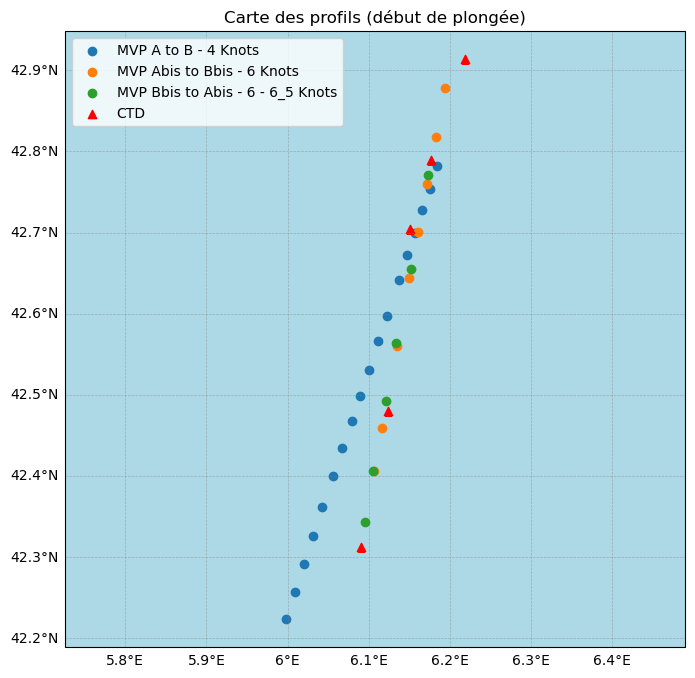

In [5]:
mvpa.plot_profile_map()

In [5]:
%matplotlib tk
mvpa.plot_TSprofile(8)

c:\Users\maxim\miniforge3\envs\oceanapp\Lib\tkinter\__init__.py:861: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args)
c:\Users\maxim\miniforge3\envs\oceanapp\Lib\tkinter\__init__.py:1967: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return self.func(*args)


In [16]:
mvpa.plot_vertical_speed(0,mean=True)

c:\Users\maxim\Documents\INGE CNRS\ESSTECH25\MVP_simple_routine\MVPAnalyzer\main.py:713: RuntimeWarning: Mean of empty slice
  v_z_down = np.nanmean(v_z_down,axis=0)


In [6]:
%matplotlib tk
mvpa.stat_compar(id_mvp=[0,6],id_ctd=[8,6],cond=True,speed=True)

c:\Users\maxim\Documents\INGE CNRS\ESSTECH25\MVP_simple_routine\MVPAnalyzer\main.py:1023: RuntimeWarning: Mean of empty slice
  mean_temp_down = np.absolute(np.nanmean(diff_temp_down, axis=0))
c:\Users\maxim\Documents\INGE CNRS\ESSTECH25\MVP_simple_routine\MVPAnalyzer\main.py:1024: RuntimeWarning: Mean of empty slice
  mean_temp_up =  np.absolute(np.nanmean(diff_temp_up, axis=0))
c:\Users\maxim\Documents\INGE CNRS\ESSTECH25\MVP_simple_routine\MVPAnalyzer\main.py:1025: RuntimeWarning: Mean of empty slice
  mean_salt_down =  np.absolute(np.nanmean(diff_salt_down, axis=0))
c:\Users\maxim\Documents\INGE CNRS\ESSTECH25\MVP_simple_routine\MVPAnalyzer\main.py:1026: RuntimeWarning: Mean of empty slice
  mean_salt_up =  np.absolute(np.nanmean(diff_salt_up, axis=0))
c:\Users\maxim\Documents\INGE CNRS\ESSTECH25\MVP_simple_routine\MVPAnalyzer\main.py:1027: RuntimeWarning: Mean of empty slice
  mean_do_down =  np.absolute(np.nanmean(diff_do_down, axis=0))
c:\Users\maxim\Documents\INGE CNRS\ESSTECH2

Conductivity RMSE (MVP - CTD):
  MVP down: 0.3133 S/m (deep: 0.0421 S/m)
  MVP up:   0.5016 S/m (deep: 0.0430 S/m)


check if there is a temporal lag between CTD and MVP

In [10]:
id_mvp = 6
id_ctd = 6

temp = mvpa.TEMP_mvp[id_mvp]
cond = mvpa.COND_mvp[id_mvp]
pres = mvpa.PRES_mvp[id_mvp]

mask = np.isnan(temp)==False
temp = temp[mask]
cond = cond[mask]
pres = pres[mask]

temp_ctd = mvpa.TEMP_ctd[id_ctd]
cond_ctd = mvpa.COND_ctd[id_ctd]
pres_ctd = mvpa.PRES_ctd[id_ctd]
mask = np.isnan(temp_ctd)==False
temp_ctd = temp_ctd[mask]
cond_ctd = cond_ctd[mask]   
pres_ctd = pres_ctd[mask]

from scipy.signal import butter, filtfilt

b,a = butter(3, 10 / 0.5 / 25 , btype='low')
temp_lowpass = filtfilt(b,a,temp)
cond_lowpass = filtfilt(b,a,cond)
pres_lowpass = filtfilt(b,a,pres)

temp_highpass = temp - temp_lowpass
cond_highpass = cond - cond_lowpass
pres_highpass = pres - pres_lowpass

temp_ctd_lowpass = filtfilt(b,a,temp_ctd)
cond_ctd_lowpass = filtfilt(b,a,cond_ctd)
pres_ctd_lowpass = filtfilt(b,a,pres_ctd)

temp_ctd_highpass = temp_ctd - temp_ctd_lowpass
cond_ctd_highpass = cond_ctd - cond_ctd_lowpass
pres_ctd_highpass = pres_ctd - pres_ctd_lowpass



import matplotlib.pyplot as plt
%matplotlib tk

plt.figure()
plt.plot(pres,temp_lowpass,label="mvp")
plt.plot(pres_ctd,temp_ctd_lowpass,label="ctd")
plt.ylabel('Temperature highpass, °C')
plt.xlabel('Pressure, dbar')
plt.title('Temperature highpass')
plt.legend()
plt.grid()
plt.show()

In [ ]:
id = 2



temp = mvpa.TEMP_mvp[id]
cond = mvpa.COND_mvp[id]
pres = mvpa.PRES_mvp[id]



mask = np.isnan(temp)==False
temp = temp[mask]
cond = cond[mask]
pres = pres[mask]



# créer une "pseudo-fréquence verticale" en utilisant des fenêtres de profondeur
window_size = 50  # points par fenêtre
step = 5          # pas de déplacement de la fenêtre
n_windows = (len(temp) - window_size) // step

amp_matrix = []
for i in range(n_windows):
    segment = temp[i*step:i*step+window_size]
    segment_fft = np.abs(np.fft.rfft(segment))
    amp_matrix.append(segment_fft)
amp_matrix = np.array(amp_matrix)


z_centers = pres[window_size//2 : window_size//2 + n_windows*step : step]
k = np.fft.rfftfreq(window_size, d=np.mean(np.diff(pres)))

f_spatial = k / (2*np.pi)

plt.figure(figsize=(6,4))
plt.pcolormesh(k, z_centers, amp_matrix, shading='auto')
plt.gca().invert_yaxis()  # profondeur descendante
plt.xlabel("Nombre d'onde vertical k [1/m]")
plt.ylabel("Profondeur [m]")
plt.title("Spectre vertical local (température vs profondeur)")
plt.colorbar(label="Amplitude")
plt.show()

C:\Users\maxim\AppData\Local\Temp\ipykernel_2776\4262711699.py:36: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(k, z_centers, amp_matrix, shading='auto')


In [ ]:
import gsw
import matplotlib.pyplot as plt
id = 3

temp = mvpa.TEMP_mvp[id]
cond = mvpa.COND_mvp[id]
pres = mvpa.PRES_mvp[id]

mask = np.isnan(temp)==False
temp = temp[mask]
cond = cond[mask]
pres = pres[mask]


fs = mvpa.freq_echant  # Sampling frequency
v_z = np.gradient(pres, 1/fs)  # Vertical speed (dP/dt)
v_z = np.convolve(v_z, np.ones(41)/41, mode='same')  # Smooth vertical speed



from scipy.signal import butter, filtfilt

b,a = butter(3, 0.2 / 0.5 / 25 , btype='low')
temp_lowpass = filtfilt(b,a,temp)
cond_lowpass = filtfilt(b,a,cond)
pres_lowpass = filtfilt(b,a,pres)

sal = gsw.SP_from_C(cond, temp, pres)
sal_lowpass = gsw.SP_from_C(cond_lowpass, temp_lowpass, pres_lowpass)
sal_lowpass2 = filtfilt(b,a,sal)

temp_highpass = temp - temp_lowpass
cond_highpass = cond - cond_lowpass
pres_highpass = pres - pres_lowpass



fig, ax1 = plt.subplots()

l1 = ax1.plot(v_z, color='tab:red', label='Vertical speed')
ax1.set_xlabel('sample number')
ax1.set_ylabel('Vertical speed', color='tab:red')
ax1.invert_yaxis()
ax1.tick_params(axis='y', labelcolor='tab:red')
ax2 = ax1.twinx()
l2 = ax2.plot(cond_highpass, color='tab:blue', label='Conductivity')
ax2.set_ylabel('Conductivity', color='tab:blue')
ax2.invert_yaxis()
ax2.tick_params(axis='y', labelcolor='tab:blue')


plt.figure()
plt.plot(sal_lowpass, pres_lowpass,label='Salinity computed after filtration')
plt.plot(sal_lowpass2, pres,label='Salinity filtered')
plt.plot(sal, pres, alpha=0.3,label='Salinity unfiltered')
plt.legend()
plt.gca().invert_yaxis()
plt.xlabel('Salinity')
plt.ylabel('Pressure (dbar)')
plt.title('Low-pass filtered Salinity profile')
plt.grid()
plt.show()


Check if there is a temporal lag between C and T

In [ ]:
temp = mvpa.TEMP_mvp[3]
cond = mvpa.COND_mvp[3]
pres = mvpa.PRES_mvp[3]

import matplotlib.pyplot as plt
%matplotlib tk
fig, ax1 = plt.subplots()


l1 = ax1.plot(pres, temp, color='tab:red', label='Temperature')
ax1.set_xlabel('sample number')
ax1.set_ylabel('Temperature (°C)', color='tab:red')
ax1.invert_yaxis()
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
l2 = ax2.plot(pres, cond, color='tab:blue', label='Conductivity')
ax2.set_ylabel('Conductivity', color='tab:blue')
ax2.invert_yaxis()
ax2.tick_params(axis='y', labelcolor='tab:blue')


lines = l1 + l2
ax1.legend(lines, [ln.get_label() for ln in lines], loc='best')
fig.tight_layout()
plt.show()

Check if there is a temporal lage between T and P

In [ ]:
id = 5



temp = mvpa.TEMP_mvp[id]
cond = mvpa.COND_mvp[id]
pres = mvpa.PRES_mvp[id]

mask = np.isnan(temp)==False
temp = temp[mask]
cond = cond[mask]
pres = pres[mask]

from scipy.signal import butter, filtfilt

b,a = butter(3, 10 / 0.5 / 25 , btype='low')
temp_lowpass = filtfilt(b,a,temp)
cond_lowpass = filtfilt(b,a,cond)
pres_lowpass = filtfilt(b,a,pres)



temp_highpass = temp - temp_lowpass
cond_highpass = cond - cond_lowpass
pres_highpass = pres - pres_lowpass


import matplotlib.pyplot as plt
%matplotlib tk
fig, ax1 = plt.subplots()


x = np.arange(len(temp))
l1 = ax1.plot(temp_highpass, color='tab:red', label='Temperature')
ax1.set_xlabel('sample number')
ax1.set_ylabel('Temperature (°C)', color='tab:red')
ax1.invert_yaxis()
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
l2 = ax2.plot(pres_highpass, color='tab:blue', label='pressure')
ax2.set_ylabel('conductivity', color='tab:blue')
ax2.invert_yaxis()
ax2.tick_params(axis='y', labelcolor='tab:blue')


lines = l1 + l2
ax1.legend(lines, [ln.get_label() for ln in lines], loc='best')
fig.tight_layout()
plt.show()

Print data spectrum

In [ ]:

id = 2



temp = mvpa.TEMP_mvp[id]
cond = mvpa.COND_mvp[id]
pres = mvpa.PRES_mvp[id]

mask = np.isnan(temp)==False
temp = temp[mask]
cond = cond[mask]
pres = pres[mask]

n = len(temp)

freq = np.fft.rfftfreq(n, d=1/mvpa.freq_echant)
fft_temp = np.fft.rfft(temp)
fft_cond = np.fft.rfft(cond)
fft_pres = np.fft.rfft(pres)

fft_temp_norm = np.abs(fft_temp)/n
fft_cond_norm = np.abs(fft_cond)/n
fft_pres_norm = np.abs(fft_pres)/n


plt.figure()
plt.semilogy(freq, fft_temp_norm, label='Temperature')
plt.semilogy(freq, fft_cond_norm, label='Conductivity')
plt.semilogy(freq, fft_pres_norm, label='Pressure')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('FFT of MVP data - profile {}'.format(id))
plt.grid()
plt.show()



In [ ]:
id = 2



temp = mvpa.TEMP_mvp[id]
cond = mvpa.COND_mvp[id]
pres = mvpa.PRES_mvp[id]



mask = np.isnan(temp)==False
temp = temp[mask]
cond = cond[mask]
pres = pres[mask]



# créer une "pseudo-fréquence verticale" en utilisant des fenêtres de profondeur
window_size = 50  # points par fenêtre
step = 5          # pas de déplacement de la fenêtre
n_windows = (len(temp) - window_size) // step

amp_matrix = []
for i in range(n_windows):
    segment = temp[i*step:i*step+window_size]
    segment_fft = np.abs(np.fft.rfft(segment))
    amp_matrix.append(segment_fft)
amp_matrix = np.array(amp_matrix)


z_centers = pres[window_size//2 : window_size//2 + n_windows*step : step]
k = np.fft.rfftfreq(window_size, d=np.mean(np.diff(pres)))

f_spatial = k / (2*np.pi)

plt.figure(figsize=(6,4))
plt.pcolormesh(k, z_centers, amp_matrix, shading='auto')
plt.gca().invert_yaxis()  # profondeur descendante
plt.xlabel("Nombre d'onde vertical k [1/m]")
plt.ylabel("Profondeur [m]")
plt.title("Spectre vertical local (température vs profondeur)")
plt.colorbar(label="Amplitude")
plt.show()

C:\Users\maxim\AppData\Local\Temp\ipykernel_2776\4262711699.py:36: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(k, z_centers, amp_matrix, shading='auto')


In [ ]:
id = 2

from scipy.signal import spectrogram


temp = mvpa.TEMP_mvp[id]
cond = mvpa.COND_mvp[id]
pres = mvpa.PRES_mvp[id]



mask = np.isnan(temp)==False
temp = temp[mask]
cond = cond[mask]
pres = pres[mask]


f, t, Sxx = spectrogram(temp, fs=mvpa.freq_echant, nperseg=256, noverlap=128)
prof = t * (pres[-1]/t[-1])

plt.figure(figsize=(8,6))
plt.pcolormesh(prof, f, 10*np.log10(Sxx), shading='auto', cmap="viridis")
plt.ylabel("Fréquence [Hz]")
plt.xlabel("Profondeur [m]")
plt.title("Spectrogramme du profil")
plt.colorbar(label="Amplitude [dB]")
plt.show()

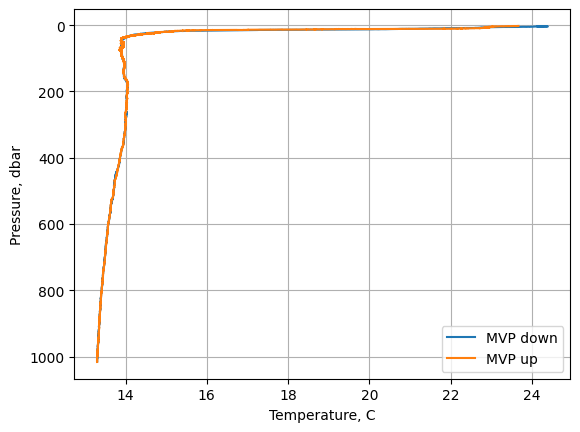

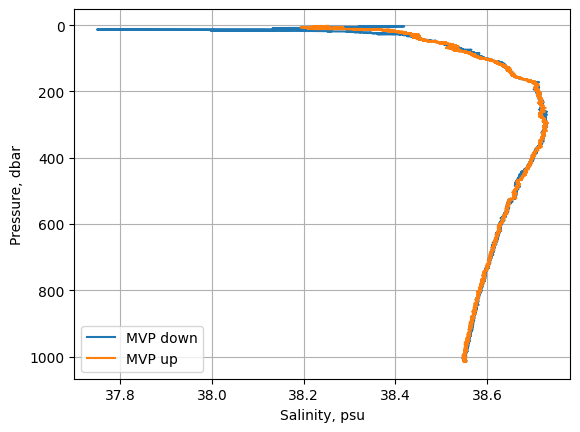

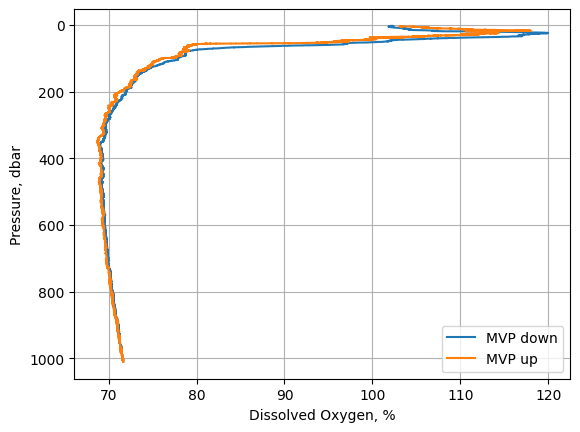

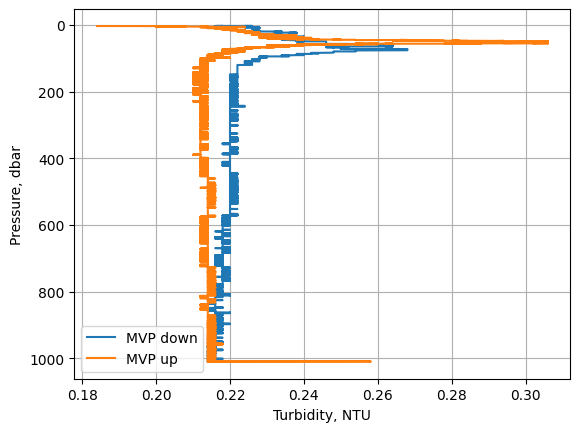

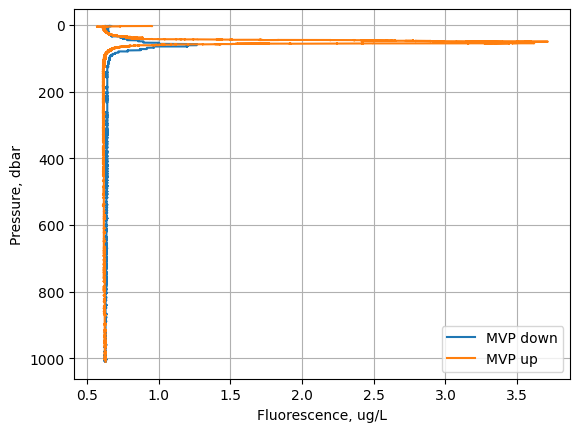

In [28]:
mvpa.plot_TSprofile(48,1)  

mvpa.plot_BGCprofile(0,1) 


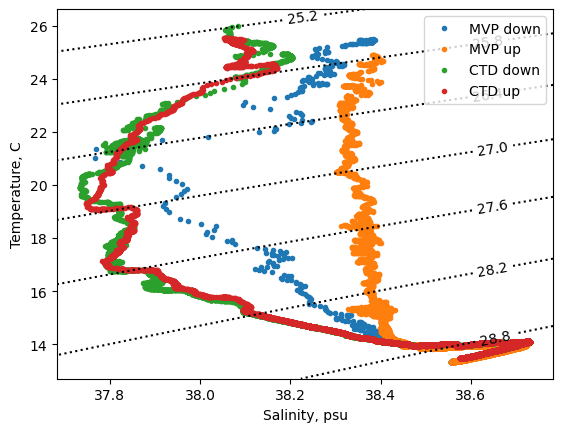

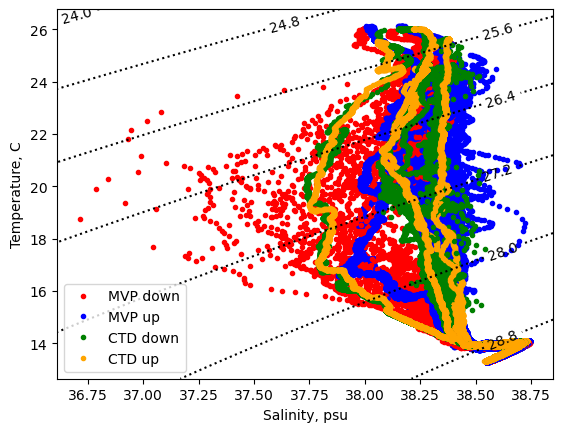

In [ ]:
mvpa.plot_diagramTS_raw(0)

mvpa.plot_diagramTS_raw()

# Speed study

comparaison A to B et Abis to Bbis

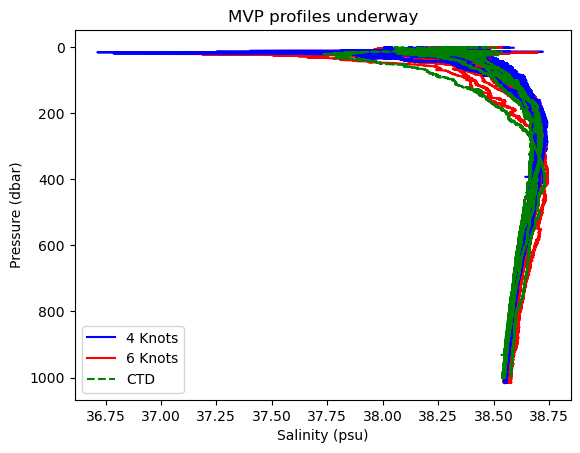

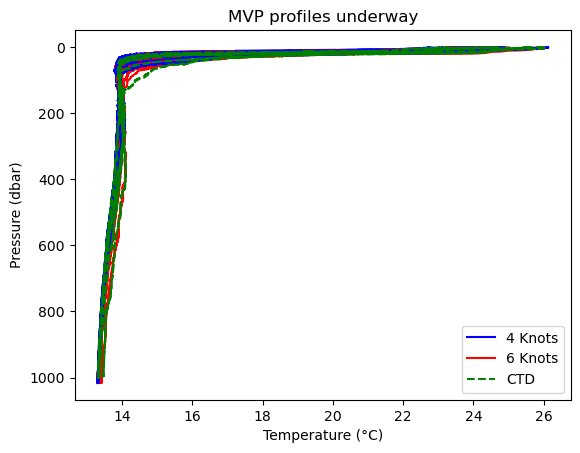

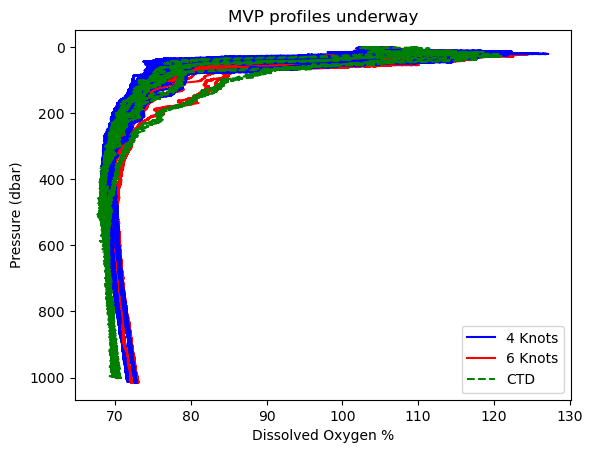

In [9]:
# two directoryies with mvps underway were loaded, 4kn and 6kn
import matplotlib.pyplot as plt
# %matplotlib tk

# Salinity profiles
plt.figure()
put_label = True
put_label2 = True
for i in range(len(mvpa.PRES_mvp)):
    if mvpa.label_mvp[i]=='Abis to Bbis - 6 Knots':
        plt.plot(mvpa.SALT_mvp[i], mvpa.PRES_mvp[i], 'r',label = '6 Knots' if put_label else "")
        put_label = False
    else:
        plt.plot(mvpa.SALT_mvp[i], mvpa.PRES_mvp[i], 'b',label = '4 Knots' if put_label2 else "")
        put_label2 = False
for i in range(len(mvpa.PRES_ctd)):
    plt.plot(mvpa.SALT_ctd[i], mvpa.PRES_ctd[i], 'g--',label = 'CTD' if i==0 else "")
plt.gca().invert_yaxis()
plt.xlabel('Salinity (psu)')
plt.ylabel('Pressure (dbar)')
plt.legend()
plt.title('MVP profiles underway')
plt.show()

# Temperature profiles
plt.figure()
put_label = True
put_label2 = True
for i in range(len(mvpa.PRES_mvp)):
    if mvpa.label_mvp[i]=='Abis to Bbis - 6 Knots':
        plt.plot(mvpa.TEMP_mvp[i], mvpa.PRES_mvp[i], 'r',label = '6 Knots' if put_label else "")
        put_label = False
    else:
        plt.plot(mvpa.TEMP_mvp[i], mvpa.PRES_mvp[i], 'b',label = '4 Knots' if put_label2 else "")
        put_label2 = False
for i in range(len(mvpa.PRES_ctd)):
    plt.plot(mvpa.TEMP_ctd[i], mvpa.PRES_ctd[i], 'g--',label = 'CTD' if i==0 else "")
plt.gca().invert_yaxis()
plt.xlabel('Temperature (°C)')
plt.ylabel('Pressure (dbar)')
plt.legend()
plt.title('MVP profiles underway')
plt.show()

# DO profiles
plt.figure()
put_label = True
put_label2 = True
for i in range(len(mvpa.PRES_mvp)):
    if mvpa.label_mvp[i]=='Abis to Bbis - 6 Knots':
        plt.plot(mvpa.DO_mvp[i], mvpa.PRES_mvp[i], 'r',label = '6 Knots' if put_label else "")
        put_label = False
    else:
        plt.plot(mvpa.DO_mvp[i], mvpa.PRES_mvp[i], 'b',label = '4 Knots' if put_label2 else "")
        put_label2 = False
for i in range(len(mvpa.PRES_ctd)):
    plt.plot(mvpa.OXY_ctd[i], mvpa.PRES_ctd[i], 'g--',label = 'CTD' if i==0 else "")
plt.gca().invert_yaxis()
plt.xlabel('Dissolved Oxygen %')
plt.ylabel('Pressure (dbar)')
plt.legend()
plt.title('MVP profiles underway')
plt.show()

Comparaison Abis to Bbis et Bbis to Abis

In [9]:
# two directoryies with mvps underway were loaded, 4kn and 6kn
import matplotlib.pyplot as plt
%matplotlib tk

# Salinity profiles
plt.figure()
put_label = True
put_label2 = True
for i in range(len(mvpa.PRES_mvp)):
    if mvpa.label_mvp[i]=='Abis to Bbis - 6 Knots':
        plt.plot(mvpa.SALT_mvp[i], mvpa.PRES_mvp[i], 'r',label = 'A to B' if put_label else "")
        put_label = False
    else:
        plt.plot(mvpa.SALT_mvp[i], mvpa.PRES_mvp[i], 'b',label = 'B to A' if put_label2 else "")
        put_label2 = False
plt.gca().invert_yaxis()
plt.xlabel('Salinity (psu)')
plt.ylabel('Pressure (dbar)')
plt.legend()
plt.title('MVP profiles underway')
plt.show()

# Temperature profiles
plt.figure()
put_label = True
put_label2 = True
for i in range(len(mvpa.PRES_mvp)):
    if mvpa.label_mvp[i]=='Abis to Bbis - 6 Knots':
        plt.plot(mvpa.TEMP_mvp[i], mvpa.PRES_mvp[i], 'r',label = 'A to B' if put_label else "")
        put_label = False
    else:
        plt.plot(mvpa.TEMP_mvp[i], mvpa.PRES_mvp[i], 'b',label = 'B to A' if put_label2 else "")
        put_label2 = False
plt.gca().invert_yaxis()
plt.xlabel('Temperature (°C)')
plt.ylabel('Pressure (dbar)')
plt.legend()
plt.title('MVP profiles underway')
plt.show()

# DO profiles
plt.figure()
put_label = True
put_label2 = True
for i in range(len(mvpa.PRES_mvp)):
    if mvpa.label_mvp[i]=='Abis to Bbis - 6 Knots':
        plt.plot(mvpa.DO_mvp[i], mvpa.PRES_mvp[i], 'r',label = 'A to B' if put_label else "")
        put_label = False
    else:
        plt.plot(mvpa.DO_mvp[i], mvpa.PRES_mvp[i], 'b',label = 'B to A' if put_label2 else "")
        put_label2 = False
plt.gca().invert_yaxis()
plt.xlabel('Dissolved Oxygen %')
plt.ylabel('Pressure (dbar)')
plt.legend()
plt.title('MVP profiles underway')
plt.show()

Comparaison A to B et ( Bbis to Abis + Abis to Bbis )

c:\Users\maxim\miniforge3\envs\oceanapp\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


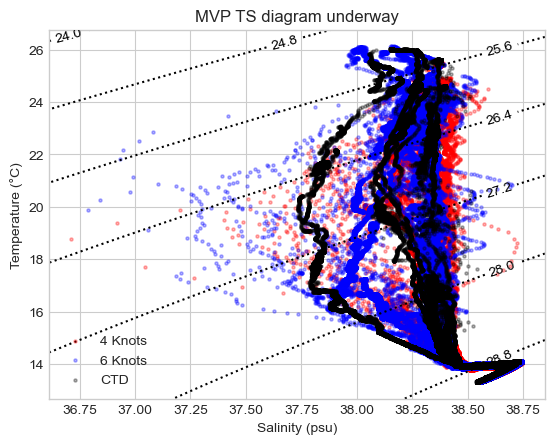

In [12]:
# two directoryies with mvps underway were loaded, 4kn and 6kn
import matplotlib.pyplot as plt
import gsw
plt.style.use('seaborn-v0_8-whitegrid')
# %matplotlib tk

# TS diagram
plt.figure()
put_label = True
put_label2 = True
put_label3 = True
for i in range(len(mvpa.PRES_mvp)):
    if mvpa.label_mvp[i]=='A to B - 4 Knots':
        plt.scatter(mvpa.SALT_mvp[i], mvpa.TEMP_mvp[i], color = 'red',label = '4 Knots' if put_label else "", alpha=0.3,s=5)
        put_label = False
    elif mvpa.label_mvp[i]=='Abis to Bbis - 6 Knots' or mvpa.label_mvp[i]=='Bbis to Abis - 6 - 6_5 Knots':
        plt.scatter(mvpa.SALT_mvp[i], mvpa.TEMP_mvp[i], color = 'blue',label = '6 Knots' if put_label2 else "", alpha=0.3,s=5)
        put_label2 = False
    else:
        plt.scatter(mvpa.SALT_mvp[i], mvpa.TEMP_mvp[i], color = 'green',label = '<1 Knot' if put_label3 else "", alpha=0.3,s=5)
        put_label3 = False
for i in range(len(mvpa.PRES_ctd)):
    plt.scatter(mvpa.SALT_ctd[i], mvpa.TEMP_ctd[i], color = 'black',label = 'CTD' if i==0 else "", alpha=0.3,s=5)


s_lim = plt.xlim()
t_lim = plt.ylim()
SA = np.linspace(s_lim[0], s_lim[1], 100)  # Absolute Salinity [g/kg]
CT = np.linspace(t_lim[0], t_lim[1], 100)
SA_grid, CT_grid = np.meshgrid(SA, CT)
# Calcul de la densité potentielle sigma0 (kg/m³ - 1000)
sigma0 = gsw.sigma0(SA_grid, CT_grid)
# Dessiner les contours (les isopycnes)
contour_plot = plt.contour(SA_grid, CT_grid, sigma0, colors='k', linestyles='dotted')
# Ajouter les étiquettes (les chiffres) le long des contours
plt.clabel(contour_plot, inline=True, fontsize=10, fmt='%1.1f')



plt.xlabel('Salinity (psu)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.title('MVP TS diagram underway')
plt.show()


In [24]:
mvpa.load_ctd_data('C:/Users/maxim/Documents/INGE CNRS/ESSTECH25/BATHYSONDE/DATA/TRAIT/CNV/')


Found 5 CTD files in the directory: C:/Users/maxim/Documents/INGE CNRS/ESSTECH25/BATHYSONDE/DATA/TRAIT/CNV/


100%|██████████| 5/5 [01:48<00:00, 21.65s/it]

CTD data loaded successfully.


In [28]:
import matplotlib.pyplot as plt
%matplotlib tk

# i = 6
# j = 6
# k = 42

i = 0
j = 8
k = 62

Pres = mvpa.PRES_mvp_corr
Temp = mvpa.TEMP_mvp_corr
Salt = mvpa.SALT_mvp_corr



plt.figure()
plt.plot(Temp[i], Pres[i], 'b',label='MVP 4 knots down')
plt.plot(Temp[i+1], Pres[i+1], 'b--',label='MVP 4 knots up')
plt.plot(mvpa.TEMP_ctd[j], mvpa.PRES_ctd[j], 'g',label = 'CTD down')
plt.plot(mvpa.TEMP_ctd[j+1], mvpa.PRES_ctd[j+1], 'g--',label = 'CTD up')
plt.plot(Temp[k], Pres[k], 'r',label='MVP 6 knots down')
plt.plot(Temp[k+1], Pres[k+1], 'r--',label='MVP 6 knots up')
plt.gca().invert_yaxis()
plt.xlabel('Temperature (°C)')
plt.ylabel('Pressure (dbar)')
plt.legend()
plt.title('MVP profiles underway')
plt.show()


plt.figure()

plt.plot(Salt[i], Pres[i], 'b',label='MVP 4 knots down')
plt.plot(Salt[i+1], Pres[i+1], 'b--',label='MVP 4 knots up')
plt.plot(mvpa.SALT_ctd[j], mvpa.PRES_ctd[j], 'g',label = 'CTD down')
plt.plot(mvpa.SALT_ctd[j+1], mvpa.PRES_ctd[j+1], 'g--',label = 'CTD up')
plt.plot(Salt[k], Pres[k], 'r',label='MVP 6 knots down')
plt.plot(Salt[k+1], Pres[k+1], 'r--',label='MVP 6 knots up')
plt.gca().invert_yaxis()
plt.xlabel('Salinity (psu)')
plt.ylabel('Pressure (dbar)')
plt.legend()
plt.title('MVP profiles underway')
plt.show()

plt.figure()
plt.plot(mvpa.DO_mvp[i], mvpa.PRES_mvp[i], 'b',label='MVP 4 knots down')
plt.plot(mvpa.DO_mvp[i+1], mvpa.PRES_mvp[i+1], 'b--',label='MVP 4 knots up')
plt.plot(mvpa.OXY_ctd[j], mvpa.PRES_ctd[j], 'g',label = 'CTD down')
plt.plot(mvpa.OXY_ctd[j+1], mvpa.PRES_ctd[j+1], 'g--',label = 'CTD up')
plt.plot(mvpa.DO_mvp[k], mvpa.PRES_mvp[k], 'r',label='MVP 6 knots down')
plt.plot(mvpa.DO_mvp[k+1], mvpa.PRES_mvp[k+1], 'r--',label='MVP 6 knots up')
plt.gca().invert_yaxis()
plt.xlabel('Dissolved Oxygen %')
plt.ylabel('Pressure (dbar)')
plt.legend()
plt.title('MVP profiles underway')
plt.show()

In [31]:
# TS diagram
import gsw
# i = 0
# j = 8
# k = 62

i = 6
j = 6
k = 42
plt.figure()



plt.scatter(mvpa.SALT_mvp_corr[i], mvpa.TEMP_mvp_corr[i], color = 'red',label = '4 Knots down',s=5)
plt.scatter(mvpa.SALT_mvp_corr[i+1], mvpa.TEMP_mvp_corr[i+1], color = 'orange',label='4 knots up',s=5)
plt.scatter(mvpa.SALT_mvp_corr[k], mvpa.TEMP_mvp_corr[k], color = 'blue',label = '6 Knots down',s=5)
plt.scatter(mvpa.SALT_mvp_corr[k+1], mvpa.TEMP_mvp_corr[k+1], color = 'cyan',label='6 knots up',s=5)
plt.scatter(mvpa.SALT_ctd[j], mvpa.TEMP_ctd[j], color = 'green',label = 'CTD down',s=5)
plt.scatter(mvpa.SALT_ctd[j+1], mvpa.TEMP_ctd[j+1], color = 'yellow',label='CTD up',s=5)


s_lim = plt.xlim()
t_lim = plt.ylim()
SA = np.linspace(s_lim[0], s_lim[1], 100)  # Absolute Salinity [g/kg]
CT = np.linspace(t_lim[0], t_lim[1], 100)
SA_grid, CT_grid = np.meshgrid(SA, CT)
# Calcul de la densité potentielle sigma0 (kg/m³ - 1000)
sigma0 = gsw.sigma0(SA_grid, CT_grid)
# Dessiner les contours (les isopycnes)
contour_plot = plt.contour(SA_grid, CT_grid, sigma0, colors='k', linestyles='dotted')
# Ajouter les étiquettes (les chiffres) le long des contours
plt.clabel(contour_plot, inline=True, fontsize=10, fmt='%1.1f')



plt.xlabel('Salinity (psu)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.title('MVP TS diagram underway')
plt.show()

In [5]:
from scipy import interpolate

def vertical_interp(Depth_mat,Mat,Depth_interp):

    Mat_Z_interp = np.zeros((len(Depth_interp)))
    Mat_Z_interp[:] = np.nan
    

    Depth_temp, ind = np.unique(Depth_mat[:],return_index=True)
    Mat_temp = Mat[ind]
    del ind
    Mat_temp = Mat_temp[np.where(np.isnan(Depth_temp)==0)[0]]
    Depth_temp = Depth_temp[np.where(np.isnan(Depth_temp)==0)[0]]
    Depth_temp = Depth_temp[np.where(np.isnan(Mat_temp)==0)[0]]
    Mat_temp = Mat_temp[np.where(np.isnan(Mat_temp)==0)[0]]
    if (len(Mat_temp)>2) & (len(Depth_temp)>2):
        ind = np.arange(np.where(Depth_interp>=np.nanmin(Depth_temp))[0][0], np.where(Depth_interp<=np.nanmax(Depth_temp))[0][-1])
        f1 = interpolate.interp1d(Depth_temp, Mat_temp,'linear')
        Mat_Z_interp[ind] = f1(Depth_interp[ind])
        del ind
    del Depth_temp, Mat_temp
    return Mat_Z_interp



RMS error temperature 4kn down:  0.25441112667999966
RMS error temperature 4kn up:  0.5379211102309407
RMS error temperature 6kn down:  0.17936083486347865
RMS error temperature 6kn up:  0.27878973943557656


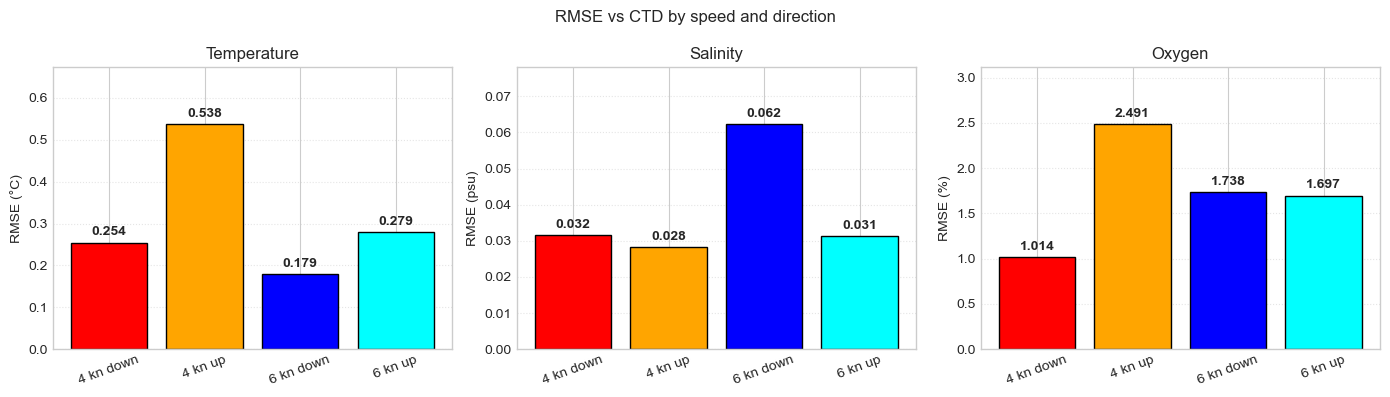

In [51]:
%matplotlib inline
i = 6
j = 6
k = 42
num_sample = 5000

pmin = np.nanmin(mvpa.PRES_mvp[i])
pmax = np.nanmax(mvpa.PRES_mvp[i])
pressure_grid = np.linspace(pmin, pmax, num_sample)


TEMP_mvp4_down_interp = vertical_interp(mvpa.PRES_mvp[i], mvpa.TEMP_mvp[i], pressure_grid)
SALT_mvp4_down_interp = vertical_interp(mvpa.PRES_mvp[i], mvpa.SALT_mvp[i], pressure_grid)
DO_mvp4_down_interp = vertical_interp(mvpa.PRES_mvp[i], mvpa.DO_mvp[i], pressure_grid)

TEMP_mvp6_down_interp = vertical_interp(mvpa.PRES_mvp[k], mvpa.TEMP_mvp[k], pressure_grid)
SALT_mvp6_down_interp = vertical_interp(mvpa.PRES_mvp[k], mvpa.SALT_mvp[k], pressure_grid)
DO_mvp6_down_interp = vertical_interp(mvpa.PRES_mvp[k], mvpa.DO_mvp[k], pressure_grid)

TEMP_ctd_down_interp = vertical_interp(mvpa.PRES_ctd[j], mvpa.TEMP_ctd[j], pressure_grid)
SALT_ctd_down_interp = vertical_interp(mvpa.PRES_ctd[j], mvpa.SALT_ctd[j], pressure_grid)
DO_ctd_down_interp = vertical_interp(mvpa.PRES_ctd[j], mvpa.OXY_ctd[j], pressure_grid)

TEMP_mvp4_up_interp = vertical_interp(mvpa.PRES_mvp[i+1], mvpa.TEMP_mvp[i+1], pressure_grid)
SALT_mvp4_up_interp = vertical_interp(mvpa.PRES_mvp[i+1], mvpa.SALT_mvp[i+1], pressure_grid)
DO_mvp4_up_interp = vertical_interp(mvpa.PRES_mvp[i+1], mvpa.DO_mvp[i+1], pressure_grid)

TEMP_mvp6_up_interp = vertical_interp(mvpa.PRES_mvp[k+1], mvpa.TEMP_mvp[k+1], pressure_grid)
SALT_mvp6_up_interp = vertical_interp(mvpa.PRES_mvp[k+1], mvpa.SALT_mvp[k+1], pressure_grid)
DO_mvp6_up_interp = vertical_interp(mvpa.PRES_mvp[k+1], mvpa.DO_mvp[k+1], pressure_grid)        

TEMP_ctd_up_interp = vertical_interp(mvpa.PRES_ctd[j+1], mvpa.TEMP_ctd[j+1], pressure_grid)
SALT_ctd_up_interp = vertical_interp(mvpa.PRES_ctd[j+1], mvpa.SALT_ctd[j+1], pressure_grid)
DO_ctd_up_interp = vertical_interp(mvpa.PRES_ctd[j+1], mvpa.OXY_ctd[j+1], pressure_grid)

diff_Temp_4kn_down = TEMP_mvp4_down_interp - TEMP_ctd_down_interp
diff_Temp_4kn_up = TEMP_mvp4_up_interp - TEMP_ctd_up_interp
diff_Temp_6kn_down = TEMP_mvp6_down_interp - TEMP_ctd_down_interp
diff_Temp_6kn_up = TEMP_mvp6_up_interp - TEMP_ctd_up_interp

diff_Salt_4kn_down = SALT_mvp4_down_interp - SALT_ctd_down_interp
diff_Salt_4kn_up = SALT_mvp4_up_interp - SALT_ctd_up_interp
diff_Salt_6kn_down = SALT_mvp6_down_interp - SALT_ctd_down_interp
diff_Salt_6kn_up = SALT_mvp6_up_interp - SALT_ctd_up_interp

diff_DO_4kn_down = DO_mvp4_down_interp - DO_ctd_down_interp
diff_DO_4kn_up = DO_mvp4_up_interp - DO_ctd_up_interp       
diff_DO_6kn_down = DO_mvp6_down_interp - DO_ctd_down_interp
diff_DO_6kn_up = DO_mvp6_up_interp - DO_ctd_up_interp


rmse_temp_4kn_down1 = np.sqrt(np.nanmean(diff_Temp_4kn_down**2))
rmse_temp_4kn_up1 = np.sqrt(np.nanmean(diff_Temp_4kn_up**2))
rmse_temp_6kn_down1 = np.sqrt(np.nanmean(diff_Temp_6kn_down**2))
rmse_temp_6kn_up1 = np.sqrt(np.nanmean(diff_Temp_6kn_up**2))
rmse_salt_4kn_down1 = np.sqrt(np.nanmean(diff_Salt_4kn_down**2))
rmse_salt_4kn_up1 = np.sqrt(np.nanmean(diff_Salt_4kn_up**2))
rmse_salt_6kn_down1 = np.sqrt(np.nanmean(diff_Salt_6kn_down**2))
rmse_salt_6kn_up1 = np.sqrt(np.nanmean(diff_Salt_6kn_up**2))
rmse_DO_4kn_down1 = np.sqrt(np.nanmean(diff_DO_4kn_down**2))
rmse_DO_4kn_up1 = np.sqrt(np.nanmean(diff_DO_4kn_up**2))
rmse_DO_6kn_down1 = np.sqrt(np.nanmean(diff_DO_6kn_down**2))
rmse_DO_6kn_up1 = np.sqrt(np.nanmean(diff_DO_6kn_up**2))


i = 0
j = 8
k = 62

pmin = np.nanmin(mvpa.PRES_mvp[i])
pmax = np.nanmax(mvpa.PRES_mvp[i])
pressure_grid = np.linspace(pmin, pmax, num_sample)


TEMP_mvp4_down_interp = vertical_interp(mvpa.PRES_mvp[i], mvpa.TEMP_mvp[i], pressure_grid)
SALT_mvp4_down_interp = vertical_interp(mvpa.PRES_mvp[i], mvpa.SALT_mvp[i], pressure_grid)
DO_mvp4_down_interp = vertical_interp(mvpa.PRES_mvp[i], mvpa.DO_mvp[i], pressure_grid)

TEMP_mvp6_down_interp = vertical_interp(mvpa.PRES_mvp[k], mvpa.TEMP_mvp[k], pressure_grid)
SALT_mvp6_down_interp = vertical_interp(mvpa.PRES_mvp[k], mvpa.SALT_mvp[k], pressure_grid)
DO_mvp6_down_interp = vertical_interp(mvpa.PRES_mvp[k], mvpa.DO_mvp[k], pressure_grid)

TEMP_ctd_down_interp = vertical_interp(mvpa.PRES_ctd[j], mvpa.TEMP_ctd[j], pressure_grid)
SALT_ctd_down_interp = vertical_interp(mvpa.PRES_ctd[j], mvpa.SALT_ctd[j], pressure_grid)
DO_ctd_down_interp = vertical_interp(mvpa.PRES_ctd[j], mvpa.OXY_ctd[j], pressure_grid)

TEMP_mvp4_up_interp = vertical_interp(mvpa.PRES_mvp[i+1], mvpa.TEMP_mvp[i+1], pressure_grid)
SALT_mvp4_up_interp = vertical_interp(mvpa.PRES_mvp[i+1], mvpa.SALT_mvp[i+1], pressure_grid)
DO_mvp4_up_interp = vertical_interp(mvpa.PRES_mvp[i+1], mvpa.DO_mvp[i+1], pressure_grid)

TEMP_mvp6_up_interp = vertical_interp(mvpa.PRES_mvp[k+1], mvpa.TEMP_mvp[k+1], pressure_grid)
SALT_mvp6_up_interp = vertical_interp(mvpa.PRES_mvp[k+1], mvpa.SALT_mvp[k+1], pressure_grid)
DO_mvp6_up_interp = vertical_interp(mvpa.PRES_mvp[k+1], mvpa.DO_mvp[k+1], pressure_grid)        

TEMP_ctd_up_interp = vertical_interp(mvpa.PRES_ctd[j+1], mvpa.TEMP_ctd[j+1], pressure_grid)
SALT_ctd_up_interp = vertical_interp(mvpa.PRES_ctd[j+1], mvpa.SALT_ctd[j+1], pressure_grid)
DO_ctd_up_interp = vertical_interp(mvpa.PRES_ctd[j+1], mvpa.OXY_ctd[j+1], pressure_grid)

diff_Temp_4kn_down = TEMP_mvp4_down_interp - TEMP_ctd_down_interp
diff_Temp_4kn_up = TEMP_mvp4_up_interp - TEMP_ctd_up_interp
diff_Temp_6kn_down = TEMP_mvp6_down_interp - TEMP_ctd_down_interp
diff_Temp_6kn_up = TEMP_mvp6_up_interp - TEMP_ctd_up_interp

diff_Salt_4kn_down = SALT_mvp4_down_interp - SALT_ctd_down_interp
diff_Salt_4kn_up = SALT_mvp4_up_interp - SALT_ctd_up_interp
diff_Salt_6kn_down = SALT_mvp6_down_interp - SALT_ctd_down_interp
diff_Salt_6kn_up = SALT_mvp6_up_interp - SALT_ctd_up_interp

diff_DO_4kn_down = DO_mvp4_down_interp - DO_ctd_down_interp
diff_DO_4kn_up = DO_mvp4_up_interp - DO_ctd_up_interp       
diff_DO_6kn_down = DO_mvp6_down_interp - DO_ctd_down_interp
diff_DO_6kn_up = DO_mvp6_up_interp - DO_ctd_up_interp


rmse_temp_4kn_down2 = np.sqrt(np.nanmean(diff_Temp_4kn_down**2))
rmse_temp_4kn_up2 = np.sqrt(np.nanmean(diff_Temp_4kn_up**2))
rmse_temp_6kn_down2 = np.sqrt(np.nanmean(diff_Temp_6kn_down**2))
rmse_temp_6kn_up2 = np.sqrt(np.nanmean(diff_Temp_6kn_up**2))
rmse_salt_4kn_down2 = np.sqrt(np.nanmean(diff_Salt_4kn_down**2))
rmse_salt_4kn_up2 = np.sqrt(np.nanmean(diff_Salt_4kn_up**2))
rmse_salt_6kn_down2 = np.sqrt(np.nanmean(diff_Salt_6kn_down**2))
rmse_salt_6kn_up2 = np.sqrt(np.nanmean(diff_Salt_6kn_up**2))
rmse_DO_4kn_down2 = np.sqrt(np.nanmean(diff_DO_4kn_down**2))
rmse_DO_4kn_up2 = np.sqrt(np.nanmean(diff_DO_4kn_up**2))
rmse_DO_6kn_down2 = np.sqrt(np.nanmean(diff_DO_6kn_down**2))
rmse_DO_6kn_up2 = np.sqrt(np.nanmean(diff_DO_6kn_up**2))

rmse_temp_4kn_down = (rmse_temp_4kn_down1 + rmse_temp_4kn_down2)/2
rmse_temp_4kn_up = (rmse_temp_4kn_up1 + rmse_temp_4kn_up2)/2
rmse_temp_6kn_down = (rmse_temp_6kn_down1 + rmse_temp_6kn_down2)/2
rmse_temp_6kn_up = (rmse_temp_6kn_up1 + rmse_temp_6kn_up2)/2    
rmse_salt_4kn_down = (rmse_salt_4kn_down1 + rmse_salt_4kn_down2)/2
rmse_salt_4kn_up = (rmse_salt_4kn_up1 + rmse_salt_4kn_up2)/2
rmse_salt_6kn_down = (rmse_salt_6kn_down1 + rmse_salt_6kn_down2)/2
rmse_salt_6kn_up = (rmse_salt_6kn_up1 + rmse_salt_6kn_up2)/2
rmse_DO_4kn_down = (rmse_DO_4kn_down1 + rmse_DO_4kn_down2)/2
rmse_DO_4kn_up = (rmse_DO_4kn_up1 + rmse_DO_4kn_up2)/2
rmse_DO_6kn_down = (rmse_DO_6kn_down1 + rmse_DO_6kn_down2)/2
rmse_DO_6kn_up = (rmse_DO_6kn_up1 + rmse_DO_6kn_up2)/2  


print('RMS error temperature 4kn down: ', rmse_temp_4kn_down)
print('RMS error temperature 4kn up: ', rmse_temp_4kn_up)
print('RMS error temperature 6kn down: ', rmse_temp_6kn_down)
print('RMS error temperature 6kn up: ', rmse_temp_6kn_up)
# print('RMS error salinity 4kn down: ', rmse_salt_4kn_down)
# print('RMS error salinity 4kn up: ', rmse_salt_4kn_up)
# print('RMS error salinity 6kn down: ', rmse_salt_6kn_down)
# print('RMS error salinity 6kn up: ', rmse_salt_6kn_up)
# print('RMS error DO 4kn down: ', rmse_DO_4kn_down)
# print('RMS error DO 4kn up: ', rmse_DO_4kn_up)
# print('RMS error DO 6kn down: ', rmse_DO_6kn_down)
# print('RMS error DO 6kn up: ', rmse_DO_6kn_up)




# plt.figure()
# plt.plot(TEMP_mvp4_down_interp,pressure_grid, 'b',label='MVP 4 knots down')
# plt.plot(TEMP_mvp4_up_interp,pressure_grid, 'b--',label='MVP 4 knots up')
# plt.plot(mvpa.TEMP_mvp[i], mvpa.PRES_mvp[i], 'c',label='MVP 4 knots down raw')
# plt.plot(mvpa.TEMP_mvp[i+1], mvpa.PRES_mvp[i+1], 'c--',label='MVP 4 knots up raw')


# plt.plot(TEMP_ctd_down_interp,pressure_grid, 'g',label = 'CTD down')
# plt.plot(TEMP_ctd_up_interp,pressure_grid, 'g--',label = 'CTD up')
# # plt.plot(pressure_grid,TEMP_mvp6_down_interp, 'r',label='MVP 6 knots down')
# # plt.plot(pressure_grid,TEMP_mvp6_up_interp, 'r--',label='MVP 6 knots up')
# plt.gca().invert_yaxis()
# plt.xlabel('Temperature (°C)')  
# plt.ylabel('Pressure (dbar)')
# plt.legend()
# plt.title('MVP profiles underway - Interpolated')
# plt.show()







labels = ['4 kn down', '4 kn up', '6 kn down', '6 kn up']

temp_rmse = [rmse_temp_4kn_down, rmse_temp_4kn_up, rmse_temp_6kn_down, rmse_temp_6kn_up]
salt_rmse = [rmse_salt_4kn_down, rmse_salt_4kn_up, rmse_salt_6kn_down, rmse_salt_6kn_up]
do_rmse   = [rmse_DO_4kn_down, rmse_DO_4kn_up, rmse_DO_6kn_down, rmse_DO_6kn_up]

colors = ['red', 'orange', 'blue', 'cyan']

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, data, title, ylabel in zip(
    axes,
    [temp_rmse, salt_rmse, do_rmse],
    ['Temperature', 'Salinity', 'Oxygen'],
    ['RMSE (°C)', 'RMSE (psu)', 'RMSE (%)']
):
    bars = ax.bar(range(len(labels)), data, color=colors, edgecolor='k')
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=20)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.grid(axis='y', linestyle=':', alpha=0.5)
    ymax = max(data) * 1.25  # 25% de marge au-dessus
    ax.set_ylim(0, ymax)
    for b in bars:
        h = b.get_height()
        if np.isfinite(h):
            ax.annotate(f'{h:.3f}', (b.get_x() + b.get_width()/2, h),
                        xytext=(0, 3), textcoords='offset points',
                        ha='center', va='bottom', fontsize=10, fontweight='bold')

fig.suptitle('RMSE vs CTD by speed and direction')
fig.tight_layout()
plt.show()




In [29]:
import matplotlib.pyplot as plt
############################

i = 6
j = 6
k = 42
num_sample = 5000

pmin = np.nanmin(mvpa.PRES_mvp[i])
pmax = np.nanmax(mvpa.PRES_mvp[i])
pressure_grid = np.linspace(pmin, pmax, num_sample)


TEMP_mvp4_down_interp = vertical_interp(mvpa.PRES_mvp[i], mvpa.TEMP_mvp[i], pressure_grid)
SALT_mvp4_down_interp = vertical_interp(mvpa.PRES_mvp[i], mvpa.SALT_mvp[i], pressure_grid)
DO_mvp4_down_interp = vertical_interp(mvpa.PRES_mvp[i], mvpa.DO_mvp[i], pressure_grid)

TEMP_mvp6_down_interp = vertical_interp(mvpa.PRES_mvp[k], mvpa.TEMP_mvp[k], pressure_grid)
SALT_mvp6_down_interp = vertical_interp(mvpa.PRES_mvp[k], mvpa.SALT_mvp[k], pressure_grid)
DO_mvp6_down_interp = vertical_interp(mvpa.PRES_mvp[k], mvpa.DO_mvp[k], pressure_grid)



TEMP_ctd_interp = vertical_interp(mvpa.PRES_ctd[j],mvpa.TEMP_ctd[j], pressure_grid)
SALT_ctd_interp = vertical_interp(mvpa.PRES_ctd[j],mvpa.SALT_ctd[j], pressure_grid)
DO_ctd_interp = vertical_interp(mvpa.PRES_ctd[j],mvpa.OXY_ctd[j], pressure_grid)

TEMP_mvp4_up_interp = vertical_interp(mvpa.PRES_mvp[i+1], mvpa.TEMP_mvp[i+1], pressure_grid)
SALT_mvp4_up_interp = vertical_interp(mvpa.PRES_mvp[i+1], mvpa.SALT_mvp[i+1], pressure_grid)
DO_mvp4_up_interp = vertical_interp(mvpa.PRES_mvp[i+1], mvpa.DO_mvp[i+1], pressure_grid)

TEMP_mvp6_up_interp = vertical_interp(mvpa.PRES_mvp[k+1], mvpa.TEMP_mvp[k+1], pressure_grid)
SALT_mvp6_up_interp = vertical_interp(mvpa.PRES_mvp[k+1], mvpa.SALT_mvp[k+1], pressure_grid)
DO_mvp6_up_interp = vertical_interp(mvpa.PRES_mvp[k+1], mvpa.DO_mvp[k+1], pressure_grid)        


diff_Temp_4kn_down = TEMP_mvp4_down_interp - TEMP_ctd_interp
diff_Temp_4kn_up = TEMP_mvp4_up_interp - TEMP_ctd_interp
diff_Temp_6kn_down = TEMP_mvp6_down_interp - TEMP_ctd_interp
diff_Temp_6kn_up = TEMP_mvp6_up_interp - TEMP_ctd_interp

diff_Salt_4kn_down = SALT_mvp4_down_interp - SALT_ctd_interp
diff_Salt_4kn_up = SALT_mvp4_up_interp - SALT_ctd_interp
diff_Salt_6kn_down = SALT_mvp6_down_interp - SALT_ctd_interp
diff_Salt_6kn_up = SALT_mvp6_up_interp - SALT_ctd_interp

diff_DO_4kn_down = DO_mvp4_down_interp - DO_ctd_interp
diff_DO_4kn_up = DO_mvp4_up_interp - DO_ctd_interp       
diff_DO_6kn_down = DO_mvp6_down_interp - DO_ctd_interp
diff_DO_6kn_up = DO_mvp6_up_interp - DO_ctd_interp


# Find index where depth >= 200 dbar; fallback to 0 if not found
i_200 = 0
for i in range(len(pressure_grid)):
    if pressure_grid[i] >= 200:
        i_200 = i
        break


rmse_temp_4kn_down2_deep = np.sqrt(np.nanmean(diff_Temp_4kn_down[i_200:]**2))
rmse_temp_4kn_up2_deep = np.sqrt(np.nanmean(diff_Temp_4kn_up[i_200:]**2))
rmse_temp_6kn_down2_deep = np.sqrt(np.nanmean(diff_Temp_6kn_down[i_200:]**2))
rmse_temp_6kn_up2_deep = np.sqrt(np.nanmean(diff_Temp_6kn_up[i_200:]**2))
rmse_salt_4kn_down2_deep = np.sqrt(np.nanmean(diff_Salt_4kn_down[i_200:]**2))
rmse_salt_4kn_up2_deep = np.sqrt(np.nanmean(diff_Salt_4kn_up[i_200:]**2))
rmse_salt_6kn_down2_deep = np.sqrt(np.nanmean(diff_Salt_6kn_down[i_200:]**2))
rmse_salt_6kn_up2_deep = np.sqrt(np.nanmean(diff_Salt_6kn_up[i_200:]**2))
rmse_DO_4kn_down2_deep = np.sqrt(np.nanmean(diff_DO_4kn_down[i_200:]**2))
rmse_DO_4kn_up2_deep = np.sqrt(np.nanmean(diff_DO_4kn_up[i_200:]**2))
rmse_DO_6kn_down2_deep = np.sqrt(np.nanmean(diff_DO_6kn_down[i_200:]**2))
rmse_DO_6kn_up2_deep = np.sqrt(np.nanmean(diff_DO_6kn_up[i_200:]**2)) 


rmse_temp_4kn_down2 = np.sqrt(np.nanmean(diff_Temp_4kn_down**2))
rmse_temp_4kn_up2 = np.sqrt(np.nanmean(diff_Temp_4kn_up**2))
rmse_temp_6kn_down2 = np.sqrt(np.nanmean(diff_Temp_6kn_down**2))
rmse_temp_6kn_up2 = np.sqrt(np.nanmean(diff_Temp_6kn_up**2))
rmse_salt_4kn_down2 = np.sqrt(np.nanmean(diff_Salt_4kn_down**2))
rmse_salt_4kn_up2 = np.sqrt(np.nanmean(diff_Salt_4kn_up**2))
rmse_salt_6kn_down2 = np.sqrt(np.nanmean(diff_Salt_6kn_down**2))
rmse_salt_6kn_up2 = np.sqrt(np.nanmean(diff_Salt_6kn_up**2))
rmse_DO_4kn_down2 = np.sqrt(np.nanmean(diff_DO_4kn_down**2))
rmse_DO_4kn_up2 = np.sqrt(np.nanmean(diff_DO_4kn_up**2))
rmse_DO_6kn_down2 = np.sqrt(np.nanmean(diff_DO_6kn_down**2))
rmse_DO_6kn_up2 = np.sqrt(np.nanmean(diff_DO_6kn_up**2))


mask = np.isfinite(TEMP_mvp4_down_interp) & np.isfinite(TEMP_ctd_interp)
coeff_temp_4kn_down2 = np.corrcoef(TEMP_mvp4_down_interp[mask], TEMP_ctd_interp[mask])[0, 1]
mask = np.isfinite(TEMP_mvp4_up_interp) & np.isfinite(TEMP_ctd_interp)
coeff_temp_4kn_up2 = np.corrcoef(TEMP_mvp4_up_interp[mask], TEMP_ctd_interp[mask])[0, 1]
mask = np.isfinite(TEMP_mvp6_down_interp) & np.isfinite(TEMP_ctd_interp)
coeff_temp_6kn_down2 = np.corrcoef(TEMP_mvp6_down_interp[mask], TEMP_ctd_interp[mask])[0, 1]
mask = np.isfinite(TEMP_mvp6_up_interp) & np.isfinite(TEMP_ctd_interp)
coeff_temp_6kn_up2 = np.corrcoef(TEMP_mvp6_up_interp[mask], TEMP_ctd_interp[mask])[0, 1]     
mask = np.isfinite(SALT_mvp4_down_interp) & np.isfinite(SALT_ctd_interp)
coeff_salt_4kn_down2 = np.corrcoef(SALT_mvp4_down_interp[mask], SALT_ctd_interp[mask])[0, 1]
mask = np.isfinite(SALT_mvp4_up_interp) & np.isfinite(SALT_ctd_interp)
coeff_salt_4kn_up2 = np.corrcoef(SALT_mvp4_up_interp[mask], SALT_ctd_interp[mask])[0, 1]
mask = np.isfinite(SALT_mvp6_down_interp) & np.isfinite(SALT_ctd_interp)
coeff_salt_6kn_down2 = np.corrcoef(SALT_mvp6_down_interp[mask], SALT_ctd_interp[mask])[0, 1]
mask = np.isfinite(SALT_mvp6_up_interp) & np.isfinite(SALT_ctd_interp)
coeff_salt_6kn_up2 = np.corrcoef(SALT_mvp6_up_interp[mask], SALT_ctd_interp[mask])[0, 1]     
mask = np.isfinite(DO_mvp4_down_interp) & np.isfinite(DO_ctd_interp)
coeff_DO_4kn_down2 = np.corrcoef(DO_mvp4_down_interp[mask], DO_ctd_interp[mask])[0, 1]
mask = np.isfinite(DO_mvp4_up_interp) & np.isfinite(DO_ctd_interp)
coeff_DO_4kn_up2 = np.corrcoef(DO_mvp4_up_interp[mask], DO_ctd_interp[mask])[0, 1]
mask = np.isfinite(DO_mvp6_down_interp) & np.isfinite(DO_ctd_interp)
coeff_DO_6kn_down2 = np.corrcoef(DO_mvp6_down_interp[mask], DO_ctd_interp[mask])[0, 1]
mask = np.isfinite(DO_mvp6_up_interp) & np.isfinite(DO_ctd_interp)
coeff_DO_6kn_up2 = np.corrcoef(DO_mvp6_up_interp[mask], DO_ctd_interp[mask])[0, 1]   


###################################################



i = 0
j = 8
k = 62
num_sample = 5000

pmin = np.nanmin(mvpa.PRES_mvp[i])
pmax = np.nanmax(mvpa.PRES_mvp[i])
pressure_grid = np.linspace(pmin, pmax, num_sample)


TEMP_mvp4_down_interp = vertical_interp(mvpa.PRES_mvp[i], mvpa.TEMP_mvp[i], pressure_grid)
SALT_mvp4_down_interp = vertical_interp(mvpa.PRES_mvp[i], mvpa.SALT_mvp[i], pressure_grid)
DO_mvp4_down_interp = vertical_interp(mvpa.PRES_mvp[i], mvpa.DO_mvp[i], pressure_grid)

TEMP_mvp6_down_interp = vertical_interp(mvpa.PRES_mvp[k], mvpa.TEMP_mvp[k], pressure_grid)
SALT_mvp6_down_interp = vertical_interp(mvpa.PRES_mvp[k], mvpa.SALT_mvp[k], pressure_grid)
DO_mvp6_down_interp = vertical_interp(mvpa.PRES_mvp[k], mvpa.DO_mvp[k], pressure_grid)


TEMP_ctd_interp = vertical_interp(mvpa.PRES_ctd[j],mvpa.TEMP_ctd[j], pressure_grid)
SALT_ctd_interp = vertical_interp(mvpa.PRES_ctd[j],mvpa.SALT_ctd[j], pressure_grid)
DO_ctd_interp = vertical_interp(mvpa.PRES_ctd[j],mvpa.OXY_ctd[j], pressure_grid)

TEMP_mvp4_up_interp = vertical_interp(mvpa.PRES_mvp[i+1], mvpa.TEMP_mvp[i+1], pressure_grid)
SALT_mvp4_up_interp = vertical_interp(mvpa.PRES_mvp[i+1], mvpa.SALT_mvp[i+1], pressure_grid)
DO_mvp4_up_interp = vertical_interp(mvpa.PRES_mvp[i+1], mvpa.DO_mvp[i+1], pressure_grid)

TEMP_mvp6_up_interp = vertical_interp(mvpa.PRES_mvp[k+1], mvpa.TEMP_mvp[k+1], pressure_grid)
SALT_mvp6_up_interp = vertical_interp(mvpa.PRES_mvp[k+1], mvpa.SALT_mvp[k+1], pressure_grid)
DO_mvp6_up_interp = vertical_interp(mvpa.PRES_mvp[k+1], mvpa.DO_mvp[k+1], pressure_grid)        


diff_Temp_4kn_down = TEMP_mvp4_down_interp - TEMP_ctd_interp
diff_Temp_4kn_up = TEMP_mvp4_up_interp - TEMP_ctd_interp
diff_Temp_6kn_down = TEMP_mvp6_down_interp - TEMP_ctd_interp
diff_Temp_6kn_up = TEMP_mvp6_up_interp - TEMP_ctd_interp

diff_Salt_4kn_down = SALT_mvp4_down_interp - SALT_ctd_interp
diff_Salt_4kn_up = SALT_mvp4_up_interp - SALT_ctd_interp
diff_Salt_6kn_down = SALT_mvp6_down_interp - SALT_ctd_interp
diff_Salt_6kn_up = SALT_mvp6_up_interp - SALT_ctd_interp

diff_DO_4kn_down = DO_mvp4_down_interp - DO_ctd_interp
diff_DO_4kn_up = DO_mvp4_up_interp - DO_ctd_interp       
diff_DO_6kn_down = DO_mvp6_down_interp - DO_ctd_interp
diff_DO_6kn_up = DO_mvp6_up_interp - DO_ctd_interp




rmse_temp_4kn_down1 = np.sqrt(np.nanmean(diff_Temp_4kn_down**2))
rmse_temp_4kn_up1 = np.sqrt(np.nanmean(diff_Temp_4kn_up**2))
rmse_temp_6kn_down1 = np.sqrt(np.nanmean(diff_Temp_6kn_down**2))
rmse_temp_6kn_up1 = np.sqrt(np.nanmean(diff_Temp_6kn_up**2))
rmse_salt_4kn_down1 = np.sqrt(np.nanmean(diff_Salt_4kn_down**2))
rmse_salt_4kn_up1 = np.sqrt(np.nanmean(diff_Salt_4kn_up**2))
rmse_salt_6kn_down1 = np.sqrt(np.nanmean(diff_Salt_6kn_down**2))
rmse_salt_6kn_up1 = np.sqrt(np.nanmean(diff_Salt_6kn_up**2))
rmse_DO_4kn_down1 = np.sqrt(np.nanmean(diff_DO_4kn_down**2))
rmse_DO_4kn_up1 = np.sqrt(np.nanmean(diff_DO_4kn_up**2))
rmse_DO_6kn_down1 = np.sqrt(np.nanmean(diff_DO_6kn_down**2))
rmse_DO_6kn_up1 = np.sqrt(np.nanmean(diff_DO_6kn_up**2))

# Find index where depth >= 200 dbar; fallback to 0 if not found
i_200 = 0
for i in range(len(pressure_grid)):
    if pressure_grid[i] >= 200:
        i_200 = i
        break


rmse_temp_4kn_down1_deep = np.sqrt(np.nanmean(diff_Temp_4kn_down[i_200:]**2))
rmse_temp_4kn_up1_deep = np.sqrt(np.nanmean(diff_Temp_4kn_up[i_200:]**2))
rmse_temp_6kn_down1_deep = np.sqrt(np.nanmean(diff_Temp_6kn_down[i_200:]**2))
rmse_temp_6kn_up1_deep = np.sqrt(np.nanmean(diff_Temp_6kn_up[i_200:]**2))
rmse_salt_4kn_down1_deep = np.sqrt(np.nanmean(diff_Salt_4kn_down[i_200:]**2))
rmse_salt_4kn_up1_deep = np.sqrt(np.nanmean(diff_Salt_4kn_up[i_200:]**2))
rmse_salt_6kn_down1_deep = np.sqrt(np.nanmean(diff_Salt_6kn_down[i_200:]**2))
rmse_salt_6kn_up1_deep = np.sqrt(np.nanmean(diff_Salt_6kn_up[i_200:]**2))
rmse_DO_4kn_down1_deep = np.sqrt(np.nanmean(diff_DO_4kn_down[i_200:]**2))
rmse_DO_4kn_up1_deep = np.sqrt(np.nanmean(diff_DO_4kn_up[i_200:]**2))
rmse_DO_6kn_down1_deep = np.sqrt(np.nanmean(diff_DO_6kn_down[i_200:]**2))
rmse_DO_6kn_up1_deep = np.sqrt(np.nanmean(diff_DO_6kn_up[i_200:]**2))   


mask = np.isfinite(TEMP_mvp4_down_interp) & np.isfinite(TEMP_ctd_interp)
coeff_temp_4kn_down1 = np.corrcoef(TEMP_mvp4_down_interp[mask], TEMP_ctd_interp[mask])[0, 1]
mask = np.isfinite(TEMP_mvp4_up_interp) & np.isfinite(TEMP_ctd_interp)
coeff_temp_4kn_up1 = np.corrcoef(TEMP_mvp4_up_interp[mask], TEMP_ctd_interp[mask])[0, 1]
mask = np.isfinite(TEMP_mvp6_down_interp) & np.isfinite(TEMP_ctd_interp)
coeff_temp_6kn_down1 = np.corrcoef(TEMP_mvp6_down_interp[mask], TEMP_ctd_interp[mask])[0, 1]
mask = np.isfinite(TEMP_mvp6_up_interp) & np.isfinite(TEMP_ctd_interp)
coeff_temp_6kn_up1 = np.corrcoef(TEMP_mvp6_up_interp[mask], TEMP_ctd_interp[mask])[0, 1]     
mask = np.isfinite(SALT_mvp4_down_interp) & np.isfinite(SALT_ctd_interp)
coeff_salt_4kn_down1 = np.corrcoef(SALT_mvp4_down_interp[mask], SALT_ctd_interp[mask])[0, 1]
mask = np.isfinite(SALT_mvp4_up_interp) & np.isfinite(SALT_ctd_interp)
coeff_salt_4kn_up1 = np.corrcoef(SALT_mvp4_up_interp[mask], SALT_ctd_interp[mask])[0, 1]
mask = np.isfinite(SALT_mvp6_down_interp) & np.isfinite(SALT_ctd_interp)
coeff_salt_6kn_down1 = np.corrcoef(SALT_mvp6_down_interp[mask], SALT_ctd_interp[mask])[0, 1]
mask = np.isfinite(SALT_mvp6_up_interp) & np.isfinite(SALT_ctd_interp)
coeff_salt_6kn_up1 = np.corrcoef(SALT_mvp6_up_interp[mask], SALT_ctd_interp[mask])[0, 1]     
mask = np.isfinite(DO_mvp4_down_interp) & np.isfinite(DO_ctd_interp)
coeff_DO_4kn_down1 = np.corrcoef(DO_mvp4_down_interp[mask], DO_ctd_interp[mask])[0, 1]
mask = np.isfinite(DO_mvp4_up_interp) & np.isfinite(DO_ctd_interp)
coeff_DO_4kn_up1 = np.corrcoef(DO_mvp4_up_interp[mask], DO_ctd_interp[mask])[0, 1]
mask = np.isfinite(DO_mvp6_down_interp) & np.isfinite(DO_ctd_interp)
coeff_DO_6kn_down1 = np.corrcoef(DO_mvp6_down_interp[mask], DO_ctd_interp[mask])[0, 1]
mask = np.isfinite(DO_mvp6_up_interp) & np.isfinite(DO_ctd_interp)
coeff_DO_6kn_up1 = np.corrcoef(DO_mvp6_up_interp[mask], DO_ctd_interp[mask])[0, 1]   



rmse_temp_4kn_down = (rmse_temp_4kn_down1 + rmse_temp_4kn_down2)/2
rmse_temp_4kn_up = (rmse_temp_4kn_up1 + rmse_temp_4kn_up2)/2
rmse_temp_6kn_down = (rmse_temp_6kn_down1 + rmse_temp_6kn_down2)/2
rmse_temp_6kn_up = (rmse_temp_6kn_up1 + rmse_temp_6kn_up2)/2
rmse_salt_4kn_down = (rmse_salt_4kn_down1 + rmse_salt_4kn_down2)/2
rmse_salt_4kn_up = (rmse_salt_4kn_up1 + rmse_salt_4kn_up2)/2
rmse_salt_6kn_down = (rmse_salt_6kn_down1 + rmse_salt_6kn_down2)/2
rmse_salt_6kn_up = (rmse_salt_6kn_up1 + rmse_salt_6kn_up2)/2
rmse_DO_4kn_down = (rmse_DO_4kn_down1 + rmse_DO_4kn_down2)/2
rmse_DO_4kn_up = (rmse_DO_4kn_up1 + rmse_DO_4kn_up2)/2
rmse_DO_6kn_down = (rmse_DO_6kn_down1 + rmse_DO_6kn_down2)/2
rmse_DO_6kn_up = (rmse_DO_6kn_up1 + rmse_DO_6kn_up2)/2

rmse_temp_4kn_down_deep = (rmse_temp_4kn_down1_deep + rmse_temp_4kn_down2_deep)/2
rmse_temp_4kn_up_deep = (rmse_temp_4kn_up1_deep + rmse_temp_4kn_up2_deep)/2
rmse_temp_6kn_down_deep = (rmse_temp_6kn_down1_deep + rmse_temp_6kn_down2_deep)/2
rmse_temp_6kn_up_deep = (rmse_temp_6kn_up1_deep + rmse_temp_6kn_up2_deep)/2
rmse_salt_4kn_down_deep = (rmse_salt_4kn_down1_deep + rmse_salt_4kn_down2_deep)/2
rmse_salt_4kn_up_deep = (rmse_salt_4kn_up1_deep + rmse_salt_4kn_up2_deep)/2
rmse_salt_6kn_down_deep = (rmse_salt_6kn_down1_deep + rmse_salt_6kn_down2_deep)/2
rmse_salt_6kn_up_deep = (rmse_salt_6kn_up1_deep + rmse_salt_6kn_up2_deep)/2
rmse_DO_4kn_down_deep = (rmse_DO_4kn_down1_deep + rmse_DO_4kn_down2_deep)/2
rmse_DO_4kn_up_deep = (rmse_DO_4kn_up1_deep + rmse_DO_4kn_up2_deep)/2
rmse_DO_6kn_down_deep = (rmse_DO_6kn_down1_deep + rmse_DO_6kn_down2_deep)/2
rmse_DO_6kn_up_deep = (rmse_DO_6kn_up1_deep + rmse_DO_6kn_up2_deep)/2

coeff_temp_4kn_down = (coeff_temp_4kn_down1 + coeff_temp_4kn_down2)/2
coeff_temp_4kn_up = (coeff_temp_4kn_up1 + coeff_temp_4kn_up2)/2
coeff_temp_6kn_down = (coeff_temp_6kn_down1 + coeff_temp_6kn_down2)/2
coeff_temp_6kn_up = (coeff_temp_6kn_up1 + coeff_temp_6kn_up2)/2
coeff_salt_4kn_down = (coeff_salt_4kn_down1 + coeff_salt_4kn_down2)/2
coeff_salt_4kn_up = (coeff_salt_4kn_up1 + coeff_salt_4kn_up2)/2
coeff_salt_6kn_down = (coeff_salt_6kn_down1 + coeff_salt_6kn_down2)/2
coeff_salt_6kn_up = (coeff_salt_6kn_up1 + coeff_salt_6kn_up2)/2
coeff_DO_4kn_down = (coeff_DO_4kn_down1 + coeff_DO_4kn_down2)/2
coeff_DO_4kn_up = (coeff_DO_4kn_up1 + coeff_DO_4kn_up2)/2
coeff_DO_6kn_down = (coeff_DO_6kn_down1 + coeff_DO_6kn_down2)/2
coeff_DO_6kn_up = (coeff_DO_6kn_up1 + coeff_DO_6kn_up2)/2










labels = ['4 kn down', '4 kn up', '6 kn down', '6 kn up']

temp_rmse = [rmse_temp_4kn_down, rmse_temp_4kn_up, rmse_temp_6kn_down, rmse_temp_6kn_up]
salt_rmse = [rmse_salt_4kn_down, rmse_salt_4kn_up, rmse_salt_6kn_down, rmse_salt_6kn_up]
do_rmse   = [rmse_DO_4kn_down, rmse_DO_4kn_up, rmse_DO_6kn_down, rmse_DO_6kn_up]

temp_rmse_deep = [rmse_temp_4kn_down_deep, rmse_temp_4kn_up_deep, rmse_temp_6kn_down_deep, rmse_temp_6kn_up_deep]
salt_rmse_deep = [rmse_salt_4kn_down_deep, rmse_salt_4kn_up_deep, rmse_salt_6kn_down_deep, rmse_salt_6kn_up_deep]
do_rmse_deep   = [rmse_DO_4kn_down_deep, rmse_DO_4kn_up_deep, rmse_DO_6kn_down_deep, rmse_DO_6kn_up_deep]


colors = ['red', 'orange', 'blue', 'cyan']

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for idx, (ax, data, data_deep, title, ylabel) in enumerate(zip(
    axes,
    [temp_rmse,  salt_rmse,  do_rmse],
    [temp_rmse_deep, salt_rmse_deep, do_rmse_deep],
    ['Temperature', 'Salinity', 'Oxygen'],
    ['RMSE (°C)', 'RMSE (psu)', 'RMSE (%)']
)):
    x = np.arange(len(labels))
    width = 0.35
    # Side-by-side grouped bars: left = All depths, right = Deep
    label_all = 'All depths' if idx == 0 else None
    label_deep = 'Deep (≥200 dbar)' if idx == 0 else None
    bars_all = ax.bar(x - width/2, data, width=width, color=colors, edgecolor='k', label=label_all)
    bars_deep = ax.bar(x + width/2, data_deep, width=width, color=colors, edgecolor='k', alpha=0.6, label=label_deep)

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=20)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.grid(axis='y', linestyle=':', alpha=0.5)
    ymax = max(max(data), max(data_deep)) * 1.25  # 25% margin above highest
    ax.set_ylim(0, ymax)

    for b in bars_all:
        h = b.get_height()
        if np.isfinite(h):
            ax.annotate(f'{h:.3f}', (b.get_x() + b.get_width()/2, h),
                        xytext=(0, 3), textcoords='offset points',
                        ha='center', va='bottom', fontsize=10, fontweight='bold')
    for b in bars_deep:
        h = b.get_height()
        if np.isfinite(h):
            ax.annotate(f'{h:.3f}', (b.get_x() + b.get_width()/2, h),
                        xytext=(0, 3), textcoords='offset points',
                        ha='center', va='bottom', fontsize=9)


    if idx == 0:
        ax.legend()

fig.suptitle('RMSE vs CTD by speed and direction')
fig.tight_layout()
plt.show()






study temporal lag between MVP and CTD

In [14]:
def find_lag(l_mvp,l_ctd,pres_mvp,pres_ctd,lowpass=False,highpass=False):

    mask = np.isnan(l_mvp)==False
    l_mvp = l_mvp[mask]
    pres_mvp = pres_mvp[mask]

    mask = np.isnan(l_ctd)==False
    l_ctd = l_ctd[mask]
    pres_ctd = pres_ctd[mask]

    if lowpass:
        from scipy.signal import butter, filtfilt
        b,a = butter(3, 10 / 0.5 / 25 , btype='low')
        l_mvp = filtfilt(b,a,l_mvp)
        l_ctd = filtfilt(b,a,l_ctd)
    if highpass:
        from scipy.signal import butter, filtfilt
        b,a = butter(3, 10 / 0.5 / 25 , btype='high')
        l_mvp = filtfilt(b,a,l_mvp)
        l_ctd = filtfilt(b,a,l_ctd)
    
    l_lag = np.arange(-10,11,0.01)
    l_corr = []

    num_sample = 3000
    pmin = np.nanmin(pres_ctd)
    pmax = np.nanmax(pres_ctd)
    pressure_grid = np.linspace(pmin, pmax, num_sample)

    # temp_ctd_interp = np.interp(pressure_grid,pres_ctd, temp_ctd_lowpass)
    import MVPAnalyzer.mvp_routines as mvp
    l_ctd_interp = mvp.vertical_interp(pres_ctd.reshape(1,-1),l_ctd.reshape(1,-1),pressure_grid)

    # print(np.sum(np.isnan(pres_ctd)))
    # print(np.all(np.diff(pres_ctd) > 0))  # True si croissant strict
    # print(np.sum(np.isnan(temp_ctd_interp)))

    for lag in l_lag:
        pres_lag = pres_mvp + lag
        # temp_interp = np.interp(pressure_grid,pres, temp_lowpass)
        l_interp =  mvp.vertical_interp(pres_lag.reshape(1,-1),l_mvp.reshape(1,-1),pressure_grid)
        mask = ~np.isnan(l_interp) & ~np.isnan(l_ctd_interp)
        l_interp = l_interp[mask]
        l_ctd_interp2 = l_ctd_interp[mask]
        corr = np.corrcoef(l_interp,l_ctd_interp2)[0,1]
        l_corr.append(corr)


    corr_max = np.nanmax(l_corr)
    lag_max = l_lag[np.nanargmax(l_corr)]
    print(f"Correlation maximale : {corr_max:.4f} au lag de {lag_max:.2f} dbar")
    return lag_max, corr_max, l_lag, l_corr
    

Correlation maximale : 0.9980 au lag de 4.36 dbar
Correlation maximale : 0.9972 au lag de 4.36 dbar
Correlation maximale : 0.9976 au lag de 1.82 dbar
Correlation maximale : 0.9968 au lag de 2.31 dbar
Correlation maximale : 0.9981 au lag de -1.95 dbar
Correlation maximale : 0.9980 au lag de -0.59 dbar
Correlation maximale : 0.9970 au lag de 2.49 dbar
Correlation maximale : 0.9961 au lag de 2.83 dbar


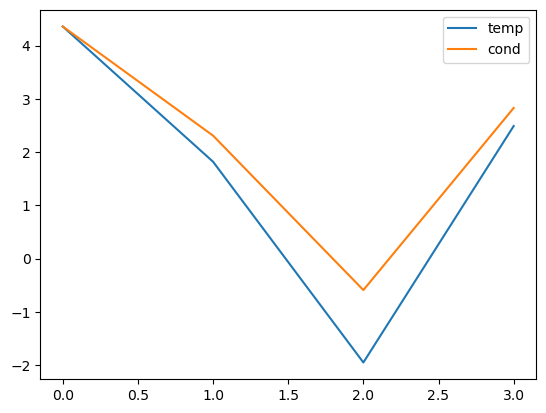

In [13]:
lag_t = []
lag_c= []

id_ctd,id_mvp = 8,0
lag_t.append(find_lag(mvpa.TEMP_mvp[id_mvp],mvpa.TEMP_ctd[id_ctd],mvpa.PRES_mvp[id_mvp],mvpa.PRES_ctd[id_ctd],lowpass=True)[0])
lag_c.append(find_lag(mvpa.COND_mvp[id_mvp],mvpa.COND_ctd[id_ctd],mvpa.PRES_mvp[id_mvp],mvpa.PRES_ctd[id_ctd],lowpass=True)[0])
id_ctd,id_mvp = 6,6
lag_t.append(find_lag(mvpa.TEMP_mvp[id_mvp],mvpa.TEMP_ctd[id_ctd],mvpa.PRES_mvp[id_mvp],mvpa.PRES_ctd[id_ctd],lowpass=True)[0])
lag_c.append(find_lag(mvpa.COND_mvp[id_mvp],mvpa.COND_ctd[id_ctd],mvpa.PRES_mvp[id_mvp],mvpa.PRES_ctd[id_ctd],lowpass=True)[0])
id_ctd,id_mvp = 6,42
lag_t.append(find_lag(mvpa.TEMP_mvp[id_mvp],mvpa.TEMP_ctd[id_ctd],mvpa.PRES_mvp[id_mvp],mvpa.PRES_ctd[id_ctd],lowpass=True)[0])
lag_c.append(find_lag(mvpa.COND_mvp[id_mvp],mvpa.COND_ctd[id_ctd],mvpa.PRES_mvp[id_mvp],mvpa.PRES_ctd[id_ctd],lowpass=True)[0])
id_ctd,id_mvp = 8,62
lag_t.append(find_lag(mvpa.TEMP_mvp[id_mvp],mvpa.TEMP_ctd[id_ctd],mvpa.PRES_mvp[id_mvp],mvpa.PRES_ctd[id_ctd],lowpass=True)[0])
lag_c.append(find_lag(mvpa.COND_mvp[id_mvp],mvpa.COND_ctd[id_ctd],mvpa.PRES_mvp[id_mvp],mvpa.PRES_ctd[id_ctd],lowpass=True)[0])


import matplotlib.pyplot as plt
plt.figure()
plt.plot(lag_t,label='temp')
plt.plot(lag_c,label='cond')
plt.legend()
plt.show()

In [ ]:
lag_tc = []
for i in range(0,len(mvpa.PRES_mvp)):

    lag_tc.append(find_lag(mvpa.COND_mvp[i],mvpa.TEMP_mvp[i],mvpa.PRES_mvp[i],mvpa.PRES_mvp[i],lowpass=False,highpass=True)[0])


plt.figure()
plt.plot(lag_tc,label='cond_temp')
plt.legend()
plt.show()